In [0]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import os
import imutils

In [0]:
!pip install opencv-contrib-python-nonfree

In [0]:
IMAGEPATH = '/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching'
path = os.path.join(IMAGEPATH,'*.*')

In [0]:
images = sorted(glob.glob(path))

In [0]:
for fname in images:
  print(fname)

/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching/campus_01.jpg
/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching/campus_02.jpg
/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching/campus_03.JPG
/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching/campus_04.JPG
/content/drive/My Drive/Colab Notebooks/CV Assignment 2/Stitching/campus_05.JPG


In [0]:
len(images)

5

In [0]:
font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

In [0]:
img = []
fig = plt.figure(figsize=(40,60))
for i, fname in enumerate(images):
  test = fig.add_subplot(1, len(images), i + 1)
  arr = cv2.imread(fname)
  test.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  img.append(cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY))
  test.set_title('Image_'+str(i+1))
fig.tight_layout()
plt.show()

In [0]:
def homography(image1,image2):
  descriptor = cv2.xfeatures2d.SIFT_create()
  keypt1, features1 = descriptor.detectAndCompute(image1,None)
  keypt2, features2 = descriptor.detectAndCompute(image2,None)
  # x = cv2.drawKeypoints(image2,keypt2,None)
  # cv2.imwrite('keypoint2.jpg',x)
  # plt.imshow(cv2.drawKeypoints(image2,keypt2,None))
  matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  rawMatches = matcher.knnMatch(features1, features2, 2)
  matches = []

# loop over the raw matches
  for m,n in rawMatches:
    if m.distance < n.distance * 0.5:
      matches.append(m)
  # print(matches)
  image3 = cv2.drawMatches(image1,keypt1,image2,keypt2,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  fig = plt.figure(figsize=(7,7))
  fig.add_subplot(1, 3, 1)
  plt.title('Keypoints_Image1')
  plt.axis('off')
  plt.imshow(cv2.drawKeypoints(image1,keypt1,None))
  # plt.show()
  # fig = plt.figure(figsize=(7,7))
  fig.add_subplot(1, 3, 3)
  plt.title('Keypoints_Image2')
  plt.axis('off')
  plt.imshow(cv2.drawKeypoints(image2,keypt2,None))
  plt.show()

  fig = plt.figure(figsize=(7,7))
  fig.add_subplot(1, 1, 1)
  plt.title('Matching_Points')
  plt.imshow(image3)
  # cv2.imwrite('matching.jpg',image3)
  plt.axis('off')
  plt.show()

  
  arr1 = np.float32([i.pt for i in keypt1])
  arr2 = np.float32([j.pt for j in keypt2])
  reprojThresh = 4 
  if len(matches) > 4:
    # construct the two sets of points
    pts1 = np.float32([arr1[m.queryIdx] for m in matches])
    pts2 = np.float32([arr2[m.trainIdx] for m in matches])
    # estimate the homography between the sets of points
    (H,_) = cv2.findHomography(pts1, pts2, cv2.RANSAC,reprojThresh)
    print('Homography Matrix')
    print(H)

    return H

In [0]:
def Laplacian_blending(img1,img2,mask,levels=6):
  G1 = img1.copy()
  G2 = img2.copy()
  GM = mask.copy()
  gp1 = [G1]
  gp2 = [G2]
  gpM = [GM]
  for i in range(levels):
    G1 = cv2.pyrDown(G1)
    G2 = cv2.pyrDown(G2)
    GM = cv2.pyrDown(GM)
    gp1.append(np.float32(G1))
    gp2.append(np.float32(G2))
    gpM.append(np.float32(GM))

  # generate Laplacian Pyramids 
  lp1  = [gp1[levels-1]] 
  lp2  = [gp2[levels-1]]
  gpMr = [gpM[levels-1]]

  for i in range(levels-1,0,-1):
    L1 = np.subtract(gp1[i-1], cv2.pyrUp(gp1[i]))
    L2 = np.subtract(gp2[i-1], cv2.pyrUp(gp2[i]))
    lp1.append(L1)
    lp2.append(L2)
    gpMr.append(gpM[i-1]) 

  # Now blend images according to mask in each level
  LS = []
  for l1,l2,gm in zip(lp1,lp2,gpMr):
    ls = l1 * gm + l2 * (1.0 - gm)
    LS.append(ls)

  # now reconstruct
  ls_ = LS[0]
  for i in range(1,levels):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

  return ls_

In [0]:
def cropImage(img):
  # gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
  thresh,dest = cv2.threshold(img,1,255,cv2.THRESH_BINARY)
  dest = dest.astype(np.uint8)
  # print(thresh.shape)
  cnts = cv2.findContours(dest, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  c = max(cnts, key=cv2.contourArea)

  (x, y, w, h) = cv2.boundingRect(c)
  crop = img[y:y + h, x:x + w]
  return crop

In [0]:
def stitching(image1,image2):
  # plt.imshow(image1,cmap='gray')
  # plt.show()
  # image1 = cv2.copyMakeBorder(image1,top=100,bottom=100,left=image1.shape[1]*4,right=0, borderType=cv2.BORDER_CONSTANT)
  H = homography(image2.astype(np.uint8),image1.astype(np.uint8))
  mask = np.ones_like(image2,dtype='float32')
  # Apply panorama correction
  # width1 = image1.shape[1] + image2.shape[1]
  width = image1.shape[1]
  height = image1.shape[0]

  # result = cv2.warpPerspective(image1, H, (width, height))
  result1 = cv2.warpPerspective(image2, H, (width, height))
  mout = cv2.warpPerspective(mask, H, (width, height))
  lpb = Laplacian_blending(result1,image1,mout,4)
  # lpb = Laplacian_blending(result,image2,mout,4)

  # result[0:image2.shape[0], 0:image2.shape[1]] = image2

  # plt.figure(figsize=(10,8))
  # # plt.imshow(cv2.cvtColor(result,cv2.COLOR_GRAY2RGB))
  # plt.imshow(result1,cmap='gray')
  # plt.title('Without')
  # plt.axis('off')
  # plt.show()
  
  result = cropImage(lpb)
  # result = cv2.warpPerspective(result, H, (width1, height))
  plt.figure(figsize=(12,8))
  # plt.imshow(cv2.cvtColor(result,cv2.COLOR_GRAY2RGB))
  plt.imshow(result,cmap='gray')
  plt.title('Result')
  plt.axis('off')
  plt.show()
  return result

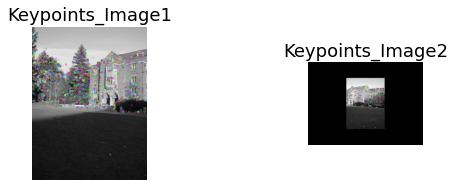

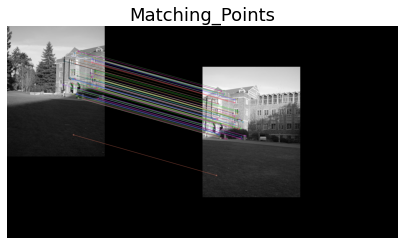

Homography Matrix
[[ 1.29187662e+00 -1.78539744e-02  1.83232526e+02]
 [ 1.60073449e-01  1.11351169e+00  1.59749546e+02]
 [ 3.04601438e-04  2.51451791e-06  1.00000000e+00]]


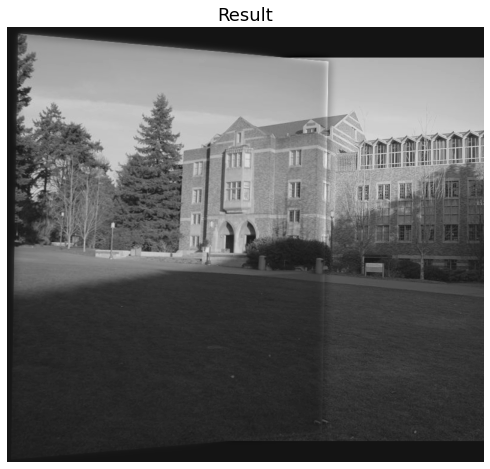

True

In [0]:
image = cv2.copyMakeBorder(img[1],top=200,bottom=200,left=img[1].shape[1],right=img[1].shape[1], borderType=cv2.BORDER_CONSTANT)
result = stitching(image,img[0])
cv2.imwrite('stitched_2_Images.jpg',result)

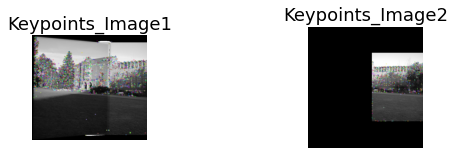

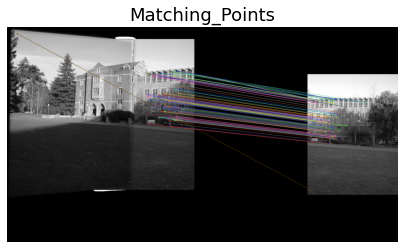

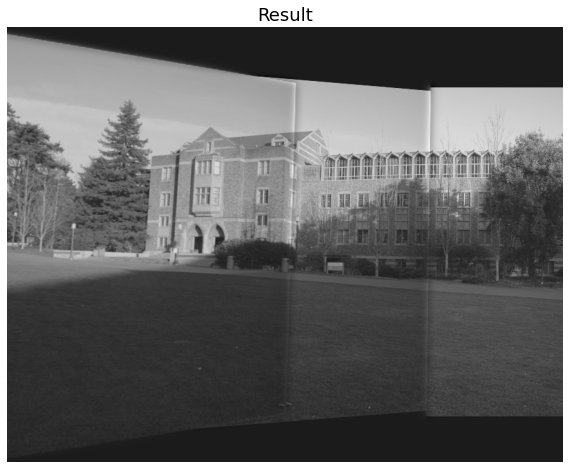

True

In [0]:
# image = cv2.copyMakeBorder(img[2],top=200,bottom=200,left=img[1].shape[1],right=0, borderType=cv2.BORDER_CONSTANT)
result = stitching(image,result)
cv2.imwrite('stitched_3_Images.jpg',result)

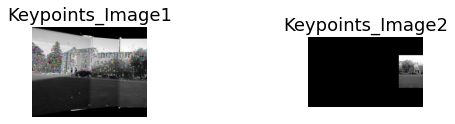

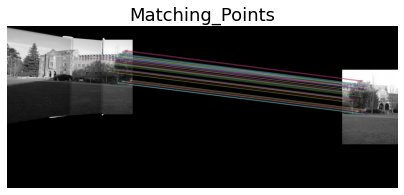

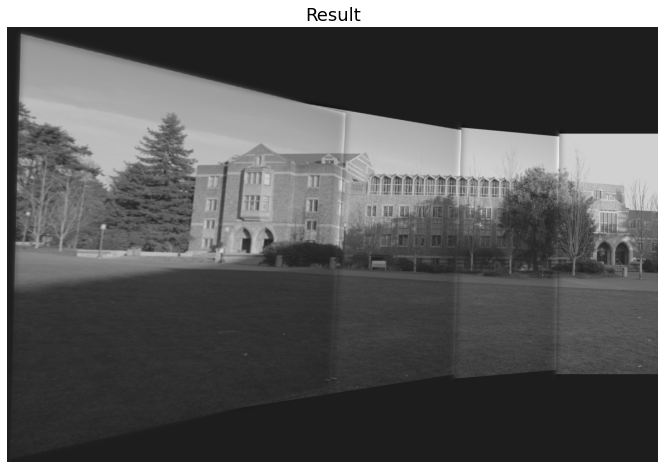

True

In [0]:
image = cv2.copyMakeBorder(img[3],top=300,bottom=300,left=img[1].shape[1]*3,right=0, borderType=cv2.BORDER_CONSTANT)
result = stitching(image,result)
cv2.imwrite('stitched_4_Images.jpg',result)

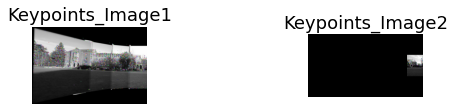

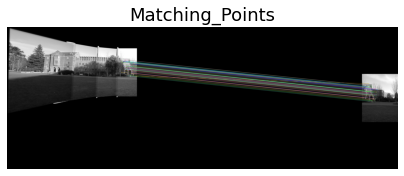

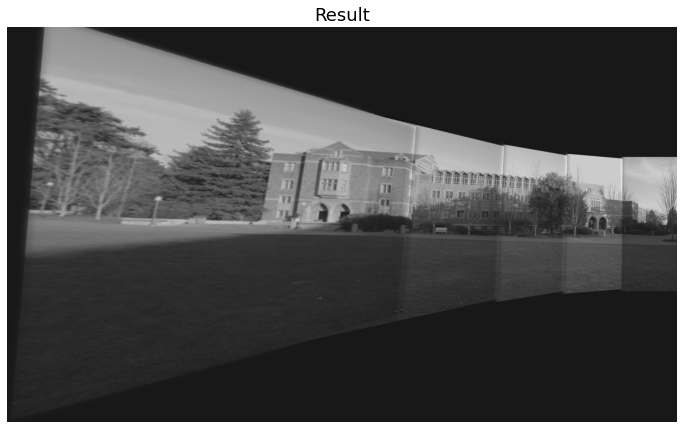

True

In [0]:
image = cv2.copyMakeBorder(img[4],top=500,bottom=500,left=img[1].shape[1]*5,right=0, borderType=cv2.BORDER_CONSTANT)
result = stitching(image,result)
cv2.imwrite('stitched_5_Images.jpg',result)